In [1]:
from math import *
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
sp.init_printing(use_unicode=True, use_latex='mathjax')
%matplotlib inline

In [2]:
VeloMPH = [] #Translational velocity of the baseball in MPH from Rapsodo
Velo = [] #Velocity in m/s
SpinM = [] #True spin of baseball in RPM
SpinS = [] #True spin of baseball in RPS
VertIN = [] #Vertical movement of each pitch from Rapsodo in inches
Vert = [] #Vertical movement in meters
HorIN = [] #Horizontal movement of each pitch in inches
Hor = [] #Horizontal movement in meters
Move = [] #Total movement in inches
S = [] #Spin factor for each pitch
SV = [] #Spin factor times velocity for each pitch
R = 0.038 #Radius of baseball in meters
A = R**2*np.pi #Cross sectional area of baseball in meters
P = 1.23 #kg/m^3 density of air at STP
XFT = 60.5 #Distance the ball travels in feet
Gam = 0.25 #N*s^2/m^4 for air at STP
D = 2*R #Diameter of baseball in meters
m = 0.145 #Mass of ball in kg
delT = 0.001 #Change in time
g = 9.81 #Gravitational constant

Import data

In [3]:
import csv
RapsodoData = []
m0 = r"C:\Users\Ryan\Desktop\Capstone\Final Project\Rapsodo Senior Project.csv" #Location of the .csv Excel file
with open(m0, newline='') as infile:
    InputReader = csv.reader(infile)
    InputHeader = next(InputReader)
    for line in InputReader:
        numline = [float(i) for i in line]
        RapsodoData.append(numline)
RapsodoData = np.array(RapsodoData)
VeloMPH = RapsodoData[:,0] #First column in Excel is velocity
SpinM = RapsodoData[:,1] #Second column is spin rate
HorIN = RapsodoData[:,2] #Third column is horizontal movement
VertIN = RapsodoData[:,3] #Fourth column is vertical movement

Calculate total movement in inches

In [4]:
for i in range(len(VeloMPH)):
    Move.append((VertIN[i]**2 + HorIN[i]**2)**(1/2)) 

Conversions

In [5]:
for i in range(len(VeloMPH)):
    Velo.append(VeloMPH[i] / 2.237) #Miles per hour to meters per second
    SpinS.append(SpinM[i] / 60) #Rotations per minute to rotations per second
    Move[i] = Move[i] * 0.0254 #Inches to meters
    Vert.append(VertIN[i] * 0.0254)#Inches to meters in absolute value
    Vert[i] = abs(Vert[i])
    Hor.append(HorIN[i] * 0.0254) #Inches to meters in absolute value
    Hor[i] = abs(Hor[i])
    
X = XFT * 0.3048 #Feet to meters

Use Shooting method for CL to match predicted model to the Rapsodo data

In [6]:
CL = [] #Lift Coefficients for each pitch
loops = 0
cases = 0
simpitches = 0
z = 1
for i in range(len(VeloMPH)):
    simpitches = simpitches + 1
    cases = cases + 1
    CLHigh = 100
    CLLow = 0.000001
    CL.append(0)
    #Movement variables
    xpos=0 #Distance the ball has traveled from the pitching machine to the plate
    ypos=0
    yposmag=0 #Horizontal movement only due to Magnus force
    zpos=5 #Pitching machine starts about 5 feet above the ground. This does not matter, only need Mag variables
    zposmag=0 #Vertical movement only due to Magnus force
    xvel=Velo[i]
    yvel=0
    yvelmag = 0 #Horizontal veloctiy only due to Magnus force
    zvel=0
    zvelmag = 0 #Vertical velocity only due to Magnus force
    uncert = 0.00000000001
    while (xpos <= X):
        loops = loops + 1
        CLAve = (CLHigh + CLLow)/2
        CL[i] = CLAve
        v = (xvel**2 + yvel**2 + zvel**2)**0.5
        #Actual positions
        xpos = (xpos + xvel*delT)
        ypos = (ypos + yvel*delT)
        zpos = (zpos + zvel*delT)
        xvel = (xvel - (Gam*D*D/m)*v*xvel*delT)
        yvel = (yvel - (Gam*D*D/m)*v*yvel*delT + 0.5*P*A*v*v*CLAve*np.sin(np.arctan(Hor[i]/Vert[i]))*delT/m)
        zvel = (zvel - g*delT - (Gam*D*D/m)*v*zvel*delT + 0.5*P*A*v*v*CLAve*np.cos(np.arctan(Hor[i]/Vert[i]))*delT/m)
        #Movement just from the Magnus Force
        yposmag = (yposmag + yvelmag*delT)
        zposmag = (zposmag + zvelmag*delT)
        yvelmag = (yvelmag + 0.5*P*A*v*v*CLAve*np.sin(np.arctan(Hor[i]/Vert[i]))*delT/m)
        zvelmag = (zvelmag + 0.5*P*A*v*v*CLAve*np.cos(np.arctan(Hor[i]/Vert[i]))*delT/m)
        
        if (75 == i and (xpos > X)):
            print (CLAve)
            print (z)
            z = z + 1
        
        #Reset all arrays if the predicted Magnus only movement does not match Rapsodo data and change lift coefficient
        if ((xpos > X) and (zposmag < Vert[i]) and abs(zposmag - Vert[i])>uncert): 
            CLLow = CLAve
            xpos=0 #Distance the ball has traveled from the pitching machine to the plate
            ypos=0
            yposmag=0 #Horizontal movement only due to Magnus force
            zpos=5 #Pitching machine starts about 5 feet above the ground. This does not matter, only need Mag variables
            zposmag=0 #Vertical movement only due to Magnus force
            xvel=Velo[i]
            yvel=0
            yvelmag = 0 #Horizontal veloctiy only due to Magnus force
            zvel=0
            zvelmag = 0 #Vertical velocity only due to Magnus force
            simpitches = simpitches + 1
        elif ((xpos > X) and (zposmag > Vert[i]) and abs(zposmag - Vert[i])>uncert): 
            CLHigh = CLAve
            xpos=0 #Distance the ball has traveled from the pitching machine to the plate
            ypos=0
            yposmag=0 #Horizontal movement only due to Magnus force
            zpos=5 #Pitching machine starts about 5 feet above the ground. This does not matter, only need Mag variables
            zposmag=0 #Vertical movement only due to Magnus force
            xvel=Velo[i]
            yvel=0
            yvelmag = 0 #Horizontal veloctiy only due to Magnus force
            zvel=0
            zvelmag = 0 #Vertical velocity only due to Magnus force
            simpitches = simpitches + 1
            

50.0000005
1
25.000000749999998
2
12.500000875
3
6.250000937499999
4
3.1250009687499998
5
1.562500984375
6
0.7812509921874999
7
0.39062599609375
8
0.19531349804687498
9
0.09765724902343749
10
0.14648537353515623
11
0.12207131127929685
12
0.13427834240722653
13
0.14038185797119138
14
0.13733010018920894
15
0.13580422129821773
16
0.13656716074371333
17
0.13694863046646114
18
0.13713936532783505
19
0.1370439978971481
20
0.13709168161249158
21
0.13706783975481984
22
0.1370797606836557
23
0.13707380021923776
24
0.13707678045144672
25
0.13707827056755123
26
0.13707901562560348
27
0.1370793881546296
28
0.13707957441914265
29
0.13707966755139916
30
0.1370796209852709
31
0.13707964426833502
32
0.13707963262680295
33
0.1370796268060369
34
0.13707962389565392
35
0.13707962535084542
36
0.13707962462324969
37
0.13707962498704757
38
0.13707962480514863
39
0.13707962471419916
40
0.1370796247596739
41
0.13707962473693652
42
0.1370796247483052
43


Test to see how many times through the while loop total and how many pitches were run

In [7]:
loops

6697856

In [8]:
cases

300

In [9]:
simpitches

12882

In [10]:
CL[75]

0.1370796247483052

Calculate Spin factor and spin factor times velocity and print the size

In [11]:
for i in range(len(Velo)):
    S.append(R*SpinS[i]/Velo[i]) #Rotations
    SV.append(R*SpinS[i]) #Rotations times meters per second
    
len(S)

300

Sort The Arrays

In [12]:
i = 1
STemp = 0
CLTemp = 0
while i < 300:
    if (S[i] < S[i - 1]):
        STemp = S[i]
        CLTemp = CL[i]
        S[i] = S[i - 1]
        CL[i] = CL[i - 1]
        S[i - 1] = STemp
        CL[i - 1] = CLTemp
        i = 1
    else:
        i = i + 1

In [13]:
fit = np.polyfit(S, CL, 4)
fitpoly = np.poly1d(fit)
fit

array([-9.27069501e+03,  1.99561365e+03, -1.72629590e+02,  8.25644440e+00,
        6.07227741e-03])

LC =  -9270.69501288483 S^4 +  1995.613650739138 S^3 +  -172.6295900167783 S^2 +  8.25644439903066 S +  0.006072277408520552


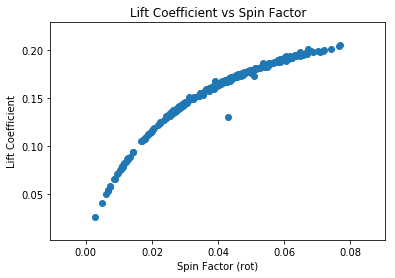

In [14]:
#plt.plot(S, fitpoly(S))
plt.scatter (S, CL)
plt.xlabel ("Spin Factor (rot)")
plt.ylabel ("Lift Coefficient")
plt.title('Lift Coefficient vs Spin Factor')
print("LC = ",fit[0],"S^4 + ",fit[1], "S^3 + ",fit[2],"S^2 + ",fit[3],"S + ", fit[4],)

In [15]:
i = 1
SVTemp = 0
CLTemp = 0
while i < 300:
    if (SV[i] < SV[i - 1]):
        SVTemp = SV[i]
        CLTemp = CL[i]
        SV[i] = SV[i - 1]
        CL[i] = CL[i - 1]
        SV[i - 1] = SVTemp
        CL[i - 1] = CLTemp
        i = 1
    else:
        i = i + 1

In [16]:
fit = np.polyfit(SV, CL, 4)
fitpoly = np.poly1d(fit)
fit

array([ 0.04404194, -0.23867696,  0.43294181, -0.24812426,  0.14619699])

LC =  0.04404194474229979 SV^4 +  -0.23867695883831924 SV^3 +  0.4329418100186847 SV^2 +  -0.2481242564504922 SV +  0.14619698662789002


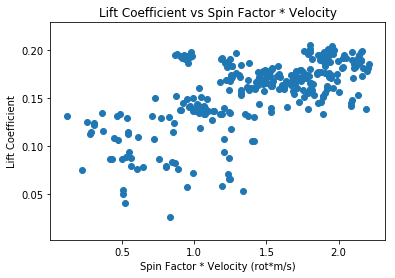

In [17]:
#plt.plot(SV, fitpoly(SV))
plt.scatter (SV, CL)
plt.xlabel ("Spin Factor * Velocity (rot*m/s)")
plt.ylabel ("Lift Coefficient")
plt.title ('Lift Coefficient vs Spin Factor * Velocity')
print("LC = ",fit[0],"SV^4 + ",fit[1], "SV^3 + ",fit[2],"SV^2 + ",fit[3],"SV + ", fit[4],)

Out of the two graphs above, this seems to be the most linear. This graph still is not perfectly linear but it is getting a lot closer. There is a y-intercept around 1 or 2 and I think that could be due to the Reynolds number. I rememeber reading that Nathan said that the Reynolds number is also a part of the lift coefficient.

In [18]:
i = 1
VeloTemp = 0
CLTemp = 0
while i < 300:
    if (Velo[i] < Velo[i - 1]):
        VeloTemp = Velo[i]
        CLTemp = CL[i]
        Velo[i] = Velo[i - 1]
        CL[i] = CL[i - 1]
        Velo[i - 1] = VeloTemp
        CL[i - 1] = CLTemp
        i = 1
    else:
        i = i + 1

In [19]:
fit = np.polyfit(Velo, CL, 4)
fitpoly = np.poly1d(fit)
fit

array([ 2.22774152e-06, -3.15581122e-04,  1.63004966e-02, -3.66845032e-01,
        3.23032684e+00])

LC =  2.2277415222859303e-06 v^4 +  -0.000315581121683164 v^3 +  0.016300496595064162 v^2 +  -0.3668450316866943 v +  3.230326843292868


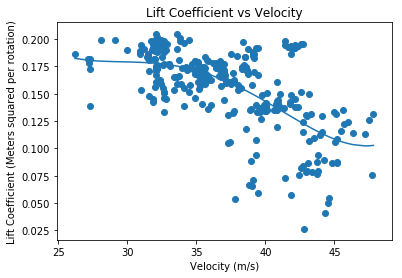

In [20]:
plt.plot (Velo, fitpoly(Velo))
plt.scatter (Velo, CL)
plt.xlabel ("Velocity (m/s)")
plt.ylabel ("Lift Coefficient (Meters squared per rotation)")
plt.title('Lift Coefficient vs Velocity')
print("LC = ",fit[0],"v^4 + ",fit[1], "v^3 + ",fit[2],"v^2 + ",fit[3],"v + ", fit[4],)

This graph is a little interesting because there seems to be a negative relationship between the lift coefficient and the velocity.

In [21]:
i = 1
SpinSTemp = 0
CLTemp = 0
while i < 300:
    if (SpinS[i] < SpinS[i - 1]):
        SpinSTemp = SpinS[i]
        CLTemp = CL[i]
        SpinS[i] = SpinS[i - 1]
        CL[i] = CL[i - 1]
        SpinS[i - 1] = SpinSTemp
        CL[i - 1] = CLTemp
        i = 1
    else:
        i = i + 1

In [22]:
fit = np.polyfit(SpinS, CL, 4)
fitpoly = np.poly1d(fit)
fit

array([ 2.15571385e-08, -2.71831135e-06,  1.14256697e-04, -2.63876274e-03,
        1.94794953e-01])

LC =  2.1557138527870347e-08 w^4 +  -2.7183113461934362e-06 w^3 +  0.00011425669748307433 w^2 +  -0.00263876274261937 w +  0.19479495337071495


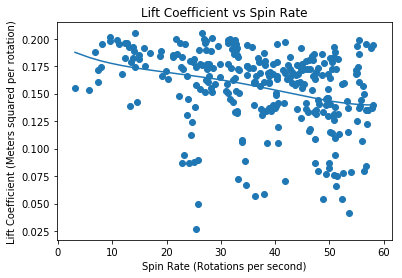

In [23]:
plt.plot (SpinS, fitpoly(SpinS))
plt.scatter (SpinS, CL)
plt.xlabel ("Spin Rate (Rotations per second)")
plt.ylabel ("Lift Coefficient (Meters squared per rotation)")
plt.title('Lift Coefficient vs Spin Rate')
print("LC = ",fit[0],"w^4 + ",fit[1], "w^3 + ",fit[2],"w^2 + ",fit[3],"w + ", fit[4],)

This graph is very similar to the Lift Coefficient vs Spin Factor Times Velocity graph because the spin factor times velocity is just the radius of the ball times the spin rate.